In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from haversine import haversine

In [2]:
def preprocess_race():

    race_df = pd.read_csv('../input/big-data-derby-2022/nyra_race_table.csv')

    race_df['race_id'] = race_df[['track_id', 'race_date', 'race_number']].astype('str').agg('_'.join, axis = 1)
    race_df.insert(0, 'race_id', race_df.pop('race_id'))
    
    
    race_df['distance_feet'] = race_df['distance_id'].apply(lambda x : int(6.6 * x)) # to_feet
    
    race_df['race_date'] = pd.to_datetime(race_df['race_date'])
    
    race_df['track_condition'] = race_df['track_condition'].str.replace(" ", "")

    # Dirt Condition Separate 
    race_df.loc[race_df['course_type'] == 'D', 'dirt_condition'] = race_df['track_condition']
    dirt_condition_order = pd.CategoricalDtype(['FT', 'GD', 'MY', 'SY'], ordered = True)
    race_df['dirt_condition'] = race_df['dirt_condition'].astype(dirt_condition_order)
    
    # Turf Condition Separate
    race_df.loc[race_df['course_type'].isin(['I', 'O', 'T']), 'turf_condition'] = race_df['track_condition']
    turf_condition_order = pd.CategoricalDtype(['FM', 'GD', 'YL', 'SF'], ordered = True)
    race_df['turf_condition'] = race_df['turf_condition'].astype(turf_condition_order)
    
    race_df.drop(['purse', 'post_time', 'track_condition'], axis = 1, inplace = True)
    
    # drop hurdle race
    race_df.drop(race_df[race_df['course_type'] == 'M'].index, inplace = True)
    
    return race_df

def preprocess_start():
    start_df = pd.read_csv('../input/big-data-derby-2022/nyra_start_table.csv', 
                        names = ['track_id', 'race_date', 'race_number', 'program_number', 'weight_carried', 'jockey', 'odds', 'position_at_finish'])
    
    start_df['race_date'] = pd.to_datetime(start_df['race_date'])
    start_df['race_id'] = start_df[['track_id', 'race_date', 'race_number']].astype('str').agg('_'.join, axis = 1)

    start_df['program_number'] = start_df['program_number'].str.replace(" ", "")
    return start_df

def preprocess_track():
    track_df = pd.read_csv('../input/big-data-derby-2022/nyra_tracking_table.csv')
    
    track_df['race_date'] = pd.to_datetime(track_df['race_date'])
#     track_df['distance_feet'] = track_df['distance_id'].apply(lambda x : int(6.6 * x))
    track_df['race_id'] = track_df[['track_id', 'race_date', 'race_number']].astype('str').agg('_'.join, axis = 1)

    track_df['program_number'] = track_df['program_number'].str.replace(" ", "")

    return track_df

# 나중에 다른 파일에 전처리 과정을 또 넣을 수도 있기 때문에 위 과정은 함수로 따로 빼겠음
# 캐글에서만 사용 가능, 다른 곳에 쓸 경우 경로명 정도만 바꾸면 될 것임

def preprocess_2022_derby():
    race_df = preprocess_race()
    start_df = preprocess_start()
    track_df = preprocess_track()
    return race_df, start_df, track_df

race_df, start_df, track_df = preprocess_2022_derby()

# 2. 데이터 탐색

## 1. 계절과 트랙

### 요약
1. 각 계절은 Spring(3, 4, 5), Summer(6, 7, 8), Autumn(9, 10, 11), Winter(12, 1, 2)로 구성
2. `Dirt` 경기가 `Turf` 경기보다 많음 :
    1. 전체 경기에 대해 $Dirt : Turf = 2 : 1$
    2. 계절로 놓고 봤을 때, `Dirt`는 항상 300경기 내외의 경기 수가 있는 반면 `Turf`는 봄, 겨울에 경기 수가 확연히 감소함
    3. `Dirt`에 관해 : 봄, 겨울에는 땅의 상태가 달리기 나빠지는 경우가 많고 반면 여름, 가을에는 달리기 좋은 상태
    
- 트랙 컨디션 [위키](https://en.wikipedia.org/wiki/Going_(horse_racing))
    - `Dirt` 
        - `FT : Fast` : 건조하고 균일하며 탄력 있는 표면
        - `GD : Good` : `FT`보다는 느린 듯
        - `MY : Muddy` : 젖었음, 고인 물은 없음
        - `SY : Sloppy` : 고인 물이 보일 정도로 물로 포화된 트랙
    - `Turf`
        - `FM : Firm` : 단단하고 탄력 있는 표면
        - `GD : Good` : `FM`보다 약간 부드러운 잔디 코스
        - `YL : Yielding` : 최근 비가 와서 지면에 상당한 양의 `give(탄성)`가 있음
        - `SF : Soft` : 수분이 많음. 말이 깊게 가라앉을 수 있음


In [3]:
# 1. 계절과 트랙의 상태
race_df['month'] = race_df['race_date'].dt.month

race_df.loc[race_df['month'].isin([3, 4, 5]), 'season'] = 'spring'
race_df.loc[race_df['month'].isin([6, 7, 8]), 'season'] = 'summer'
race_df.loc[race_df['month'].isin([9, 10, 11]), 'season'] = 'autumn'
race_df.loc[race_df['month'].isin([12, 1, 2]), 'season'] = 'winter'

season_order = pd.CategoricalDtype(['spring', 'summer', 'autumn', 'winter'],
                                        ordered = True)
race_df['season'] = race_df['season'].astype(season_order)

race_df

,race_id,track_id,race_date,race_number,distance_id,course_type,run_up_distance,race_type,distance_feet,dirt_condition,turf_condition,month,season
0,AQU_2019-01-01_1,AQU,2019-01-01,1,650,D,36,AOC,4290,MY,NaN,1,winter
1,AQU_2019-01-01_2,AQU,2019-01-01,2,600,D,48,MCL,3960,MY,NaN,1,winter
2,AQU_2019-01-01_3,AQU,2019-01-01,3,550,D,54,MCL,3630,MY,NaN,1,winter
3,AQU_2019-01-01_4,AQU,2019-01-01,4,900,D,101,AOC,5940,MY,NaN,1,winter
4,AQU_2019-01-01_5,AQU,2019-01-01,5,700,D,60,ALW,4620,MY,NaN,1,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,SAR_2019-09-02_7,SAR,2019-09-02,7,900,D,79,CLM,5940,SY,NaN,9,autumn
1996,SAR_2019-09-02_8,SAR,2019-09-02,8,700,D,32,AOC,4620,SY,NaN,9,autumn
1997,SAR_2019-09-02_9,SAR,2019-09-02,9,850,I,22,STK,5610,NaN,SF,9,autumn
1998,SAR_2019-09-02_10,SAR,2019-09-02,10,700,D,32,STK,4620,SY,NaN,9,autumn


- 색은 여기서 뽑아옴 : [color-hex.com](https://www.color-hex.com/)
- seaborn의 기능을 이용해도 되긴 함

In [4]:
dirt_color = ['#783f04', '#bb8632', '#cca466', '#ddc299']
dirt_palette = sns.color_palette(dirt_color, as_cmap = True)

turf_color = ['#38761d', '#5f914a', '#87ac77', '#afc8a4']
turf_palette = sns.color_palette(turf_color, as_cmap = True)


In [5]:
temp_df = race_df.groupby('course_type')['race_id'].count().to_frame().reset_index().rename(columns = {'race_id' : 'races'})
temp_df.loc[temp_df['course_type'] == 'T', 'races'] = temp_df.loc[1:, 'races'].sum()
temp_df.drop(temp_df[temp_df['course_type'].isin(['I', 'O'])].index, inplace = True)

Text(0.5, 1.0, 'Total Races and Course Type')

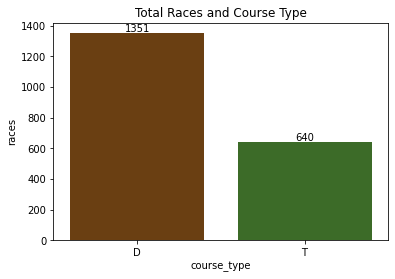

In [6]:
ax = sns.barplot(data = temp_df, x = 'course_type', y = 'races', palette = ['#783f04', '#38761d'])
ax.bar_label(ax.containers[0])
plt.title('Total Races and Course Type')

- 문제상황 : season으로 묶인 course_type 중 I, O, T를 T에 합쳐서 세고 싶음
    - 그냥 처음에 넣을 때 바꿔넣으면 되잖?

In [7]:
temp_df = race_df.copy()
temp_df.loc[temp_df['course_type'].isin(['I', 'O']), 'course_type'] = 'T'
temp_df = temp_df.groupby(['season', 'course_type'])['race_id'].count().to_frame().reset_index().rename(columns = {'race_id' : 'races'})
# temp_df.drop(temp_df[temp_df['course_type'].isin(['I', 'O'])].index, inplace = True)

Text(0.5, 1.0, 'Races & Season')

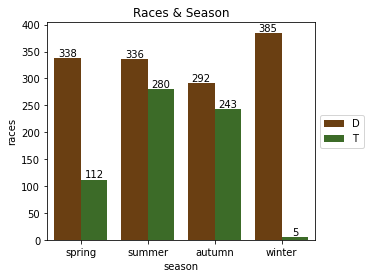

In [8]:
ax = sns.barplot(data = temp_df, x = 'season', y = 'races', hue = 'course_type', palette = ['#783f04', '#38761d'])

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

plt.title('Races & Season')

In [9]:
sub_dirt_df = (race_df.groupby(['season', 'dirt_condition'])['race_id'].count()
                                                                      .to_frame()
                                                                      .reset_index()
                                                                      .rename(columns = {"race_id" : 'counts'})
              )
sub_dirt_df['season_counts'] = sub_dirt_df.groupby('season')['counts'].transform('sum')
sub_dirt_df['seasonal_condition_rate'] = sub_dirt_df.apply(lambda x : round((x['counts'] / x ['season_counts']), 2), axis = 1)
sub_dirt_df = sub_dirt_df[sub_dirt_df['counts'] != 0]

sub_turf_df = race_df.copy()
sub_turf_df.loc[sub_turf_df['course_type'].isin(['I', 'O']), 'course_type'] = 'T'
sub_turf_df = (race_df.groupby(['season', 'turf_condition'])['race_id'].count()
                                                                       .to_frame()
                                                                       .reset_index()
                                                                       .rename(columns = {"race_id" : 'counts'})
              )
sub_turf_df = sub_turf_df[sub_turf_df['counts'] != 0]

In [10]:
sub_dirt_df.head(2)

,season,dirt_condition,counts,season_counts,seasonal_condition_rate
0,spring,FT,244,338,0.72
1,spring,GD,18,338,0.05


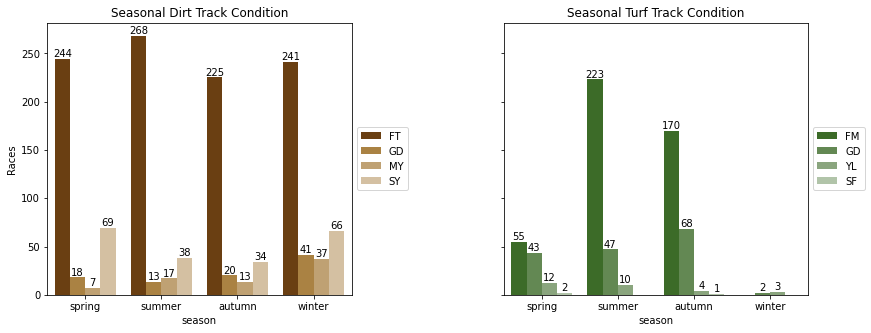

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey = True)


sns.barplot(data = sub_dirt_df,
              x = 'season',
              y = 'counts',
             hue = 'dirt_condition',
             ax = ax[0],
             palette = dirt_palette
           )

# 동시에 표시하려고 했으나 그래프가 너무 지저분해져서 제외함
# ax02 = ax[0].twinx()
# sns.lineplot(data = sub_dirt_df[sub_dirt_df['dirt_condition'].isin(['FT', 'SY'])][:], 
#             x = 'season', 
#             y = 'seasonal_condition_rate', 
#             hue = 'dirt_condition',
#             ax = ax02,
#             palette = dirt_palette,
#             alpha = 0.75)
# ax02.legend().set_visible(False)

ax[0].set_title('Seasonal Dirt Track Condition')
ax[0].set_ylabel('Races')
ax[0].legend().set_visible(False)
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[0].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))



sns.barplot(data = sub_turf_df,
              x = 'season',
              y = 'counts',
             hue = 'turf_condition',
             ax = ax[1],
           palette = turf_palette
           )

ax[1].set_title('Seasonal Turf Track Condition')
ax[1].set_ylabel(None)

# legend
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax[1].legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

for i in range(2):
    for j in range(4):
        ax[i].bar_label(ax[i].containers[j])

Text(0.5, 1.0, 'Seasonal Dirt Condition Rate : FT vs SY')

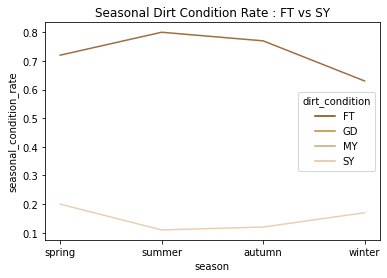

In [12]:

sns.lineplot(data = (sub_dirt_df
                     [sub_dirt_df['dirt_condition'].isin(['FT', 'SY'])][:]
                    ), 
            x = 'season', 
            y = 'seasonal_condition_rate', 
            hue = 'dirt_condition',
            palette = dirt_palette,
            alpha = 0.75)
# plt.gca().legend().set_visible(False)

plt.title('Seasonal Dirt Condition Rate : FT vs SY')

## 2. 기수

In [13]:
merged_df = start_df.merge(race_df,
                on = ['race_id'])
# merged_df.insert(0, 'race_id', merged_df.pop('race_id'))
merged_df.head(2)

,track_id_x,race_date_x,race_number_x,program_number,weight_carried,jockey,odds,position_at_finish,race_id,track_id_y,...,race_number_y,distance_id,course_type,run_up_distance,race_type,distance_feet,dirt_condition,turf_condition,month,season
0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,AQU_2019-01-01_1,AQU,...,1,650,D,36,AOC,4290,MY,NaN,1,winter
1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,AQU_2019-01-01_1,AQU,...,1,650,D,36,AOC,4290,MY,NaN,1,winter


### 1. 기수와 출전한 경기 수, 평균 순위, 코스 타입 당 평균 순위
#### 요약 : 모든 기수 데이터를 사용
1. 귀무가설은 "경기 수와 출전 순위는 아무런 관계가 없다"일 거고, 데이터를 어떻게 준비하느냐에 따라 다른 결과가 나왔음.
    1. **`IQR`을 넘는 범위 제외** : 경기수와 평균 순위에 관해, **상관관계가 거의 없음 + p-value 값도 크게 나옴**
    2. **전체 데이터** : **상관계수가 높게 나옴 + p-value도 귀무가설을 기각할 수 있는 수치가 나옴**
3. 기수 각각을 산점도에 놨을 때 순위와, 출전수에 대해 기수들의 순위를 평균으로 통합한 다음 산점도에 놨을 때, 상관계수와 p-value값은 다르게 나옴

- 무엇이 맞다고 할 수 있을까?
    - 총 162명인데 `Upper IQR Boundary : 82경기` 이상 뛴 기수가 29명으로 약 17%를 차지한다. 무시할만한 수치는 아니라고 생각됨.

In [14]:
jockey_df = merged_df.loc[:, ['race_id', 'jockey', 'course_type', 'dirt_condition', 'turf_condition', 'position_at_finish']]
jockey_df['appearance'] = jockey_df.groupby('jockey')['race_id'].transform('count')

In [15]:
jockey_df['avg_rank_by_jockey']= jockey_df.groupby(['jockey'])['position_at_finish'].transform('mean')
jockey_app_rank = jockey_df[['jockey', 'appearance', 'avg_rank_by_jockey']].drop_duplicates()

In [16]:
jockey_app_rank['jockey'].count()
jockey_app_rank.describe()

,appearance,avg_rank_by_jockey
count,162.000000,162.000000
mean,91.617284,5.224499
std,224.444328,1.800853
min,1.000000,1.000000
25%,1.250000,4.206631
50%,4.000000,5.013761
75%,33.500000,6.030612
max,1274.000000,13.000000


Text(0.5, 1.0, 'Appearance Data Except Outliers')

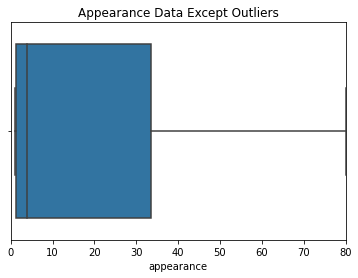

In [17]:
# scatter와 box 동시 표시
# sns.swarmplot(data = jockey_app_rank, x = 'appearance')
sns.boxplot(data = jockey_app_rank, x = 'appearance')
sns.scatterplot(data = jockey_app_rank, x = 'appearance')
plt.xlim([0, 80])
plt.title("Appearance Data Except Outliers")

In [18]:
# upper_boundary 구하기
x = jockey_app_rank['appearance']
q_75, q_25 = np.percentile(x, [75, 25])

iqr = q_75 - q_25
up_boundary = q_75 + 1.5 * iqr
up_boundary

81.875

In [19]:
jockey_app_rank[jockey_app_rank['appearance'] >= up_boundary]['jockey'].count()

29

#### 1. Appearance : IQR을 넘는 이상치 데이터들을 제외

In [20]:
jockey_app_rank_inner = jockey_app_rank[jockey_app_rank['appearance'] <= up_boundary][:]
jockey_app_rank_inner

,jockey,appearance,avg_rank_by_jockey
3,Jomar Garcia,2,5.000000
41,Frankie Pennington,4,4.750000
57,Joel Sone,17,5.882353
74,Julio Correa,68,5.029412
85,Pablo Fragoso,40,6.325000
...,...,...,...
13691,Jose Angel Garcia,1,7.000000
13847,Jose Antonio Gallego,4,7.500000
13866,Sophie Doyle,1,3.000000
14247,Martin Chuan,1,12.000000


corcoef = 0.03427458421381542, p-value = 0.6953111045100181


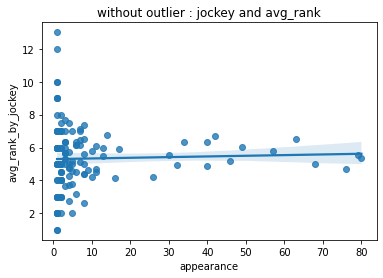

In [21]:
sns.regplot(data = jockey_app_rank_inner, x = 'appearance', y = 'avg_rank_by_jockey')
plt.title("without outlier : jockey and avg_rank")
r, p_value = stats.pearsonr(x = jockey_app_rank_inner['appearance'], y = jockey_app_rank_inner['avg_rank_by_jockey'])
print(f"corcoef = {r}, p-value = {p_value}")

corcoef = 0.14844805110940265, p-value = 0.4421747777483574


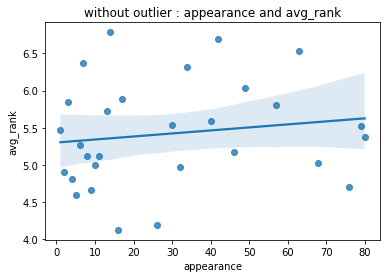

In [22]:
# 이상치를 제외한 플롯
temp_df = jockey_app_rank_inner.groupby('appearance')['avg_rank_by_jockey'].mean().to_frame().reset_index().rename(columns = {'avg_rank_by_jockey' : 'avg_rank'})
sns.regplot(data = temp_df, x = 'appearance', y = 'avg_rank')
plt.title('without outlier : appearance and avg_rank')
r, p_value =stats.pearsonr(x = temp_df['appearance'], y = temp_df['avg_rank'])
print(f"corcoef = {r}, p-value = {p_value}")

#### 2. 이상치 데이터를 제거하지 않고 Plot
- 전체 기수는 162명, 경기 출전 수의 `nunique()`값은 58이다.

(-0.16868297382516895, 0.03189222439937974)

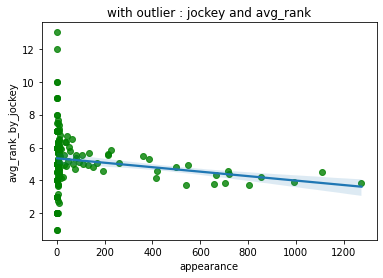

In [23]:
sns.regplot(data = jockey_app_rank,
               x = 'appearance',
               y = 'avg_rank_by_jockey',
#                ci = None,
               scatter_kws = {'color' : 'green'})

plt.title("with outlier : jockey and avg_rank")
stats.pearsonr(x = jockey_app_rank['appearance'], y = jockey_app_rank['avg_rank_by_jockey'])

In [24]:
jockey_app_rank['appearance'].nunique()

58

In [25]:
dirt_appear_df = (jockey_df[jockey_df['course_type'] == 'D'].groupby('jockey')['race_id'].count()
                                                                                         .to_frame()
                                                                                         .reset_index()
                                                                                         .rename(columns = {'race_id' : 'dirt_appearance'}))
turf_appear_df = (jockey_df[jockey_df['course_type'].isin(['T', 'I', 'O'])].groupby('jockey')['race_id'].count()
                                                                                                     .to_frame()
                                                                                                     .reset_index()
                                                                                                     .rename(columns = {'race_id' : 'turf_appearance'}))

jockey_df = (jockey_df.merge(dirt_appear_df, how = 'left', on = 'jockey')
                      .merge(turf_appear_df, how = 'left', on = 'jockey'))
jockey_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14842 entries, 0 to 14841
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   race_id             14842 non-null  object  
 1   jockey              14842 non-null  object  
 2   course_type         14842 non-null  object  
 3   dirt_condition      9467 non-null   category
 4   turf_condition      5375 non-null   category
 5   position_at_finish  14842 non-null  int64   
 6   appearance          14842 non-null  int64   
 7   avg_rank_by_jockey  14842 non-null  float64 
 8   dirt_appearance     14795 non-null  float64 
 9   turf_appearance     14680 non-null  float64 
dtypes: category(2), float64(3), int64(2), object(3)
memory usage: 1.0+ MB


In [26]:
jockey_df[['jockey', 'appearance']].drop_duplicates().describe()
# jockey_df[['jockey', 'appearance']].drop_duplicates().plot(kind = 'box')


,appearance
count,162.000000
mean,91.617284
std,224.444328
min,1.000000
25%,1.250000
50%,4.000000
75%,33.500000
max,1274.000000


In [27]:
jockey_df['dirt_appearance'].fillna(0, inplace = True)
jockey_df['turf_appearance'].fillna(0, inplace = True)

jockey_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14842 entries, 0 to 14841
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   race_id             14842 non-null  object  
 1   jockey              14842 non-null  object  
 2   course_type         14842 non-null  object  
 3   dirt_condition      9467 non-null   category
 4   turf_condition      5375 non-null   category
 5   position_at_finish  14842 non-null  int64   
 6   appearance          14842 non-null  int64   
 7   avg_rank_by_jockey  14842 non-null  float64 
 8   dirt_appearance     14842 non-null  float64 
 9   turf_appearance     14842 non-null  float64 
dtypes: category(2), float64(3), int64(2), object(3)
memory usage: 1.0+ MB


In [28]:
# 1. 출전 수와 평균 순위
jockey_df['appearance'] = jockey_df.groupby('jockey')['race_id'].transform('nunique')
app_rank = (jockey_df.groupby('appearance')['position_at_finish'].mean()
                                                                 .to_frame()
                                                                 .reset_index()
                                                                 .rename(columns = {'position_at_finish' : 'avg_rank'}))

# 2. Dirt 출전 수와 평균 순위
dirt_app_rank = (jockey_df[jockey_df['course_type'] == 'D'].groupby('dirt_appearance')['position_at_finish']
                                                           .mean()
                                                           .to_frame()
                                                           .reset_index()
                                                           .rename(columns = {'position_at_finish' : 'dirt_avg_rank'}))

turf_app_rank = (jockey_df[jockey_df['course_type'].isin(['T', 'I', 'O'])].groupby('turf_appearance')['position_at_finish']
                                                                           .mean()
                                                                           .to_frame()
                                                                           .reset_index()
                                                                           .rename(columns = {'position_at_finish' : 'turf_avg_rank'}))

상관계수 : -0.631658005069876, p-value : 1.0554257650012832e-07


Text(0.5, 1.0, 'Total Appearance and Average Rank')

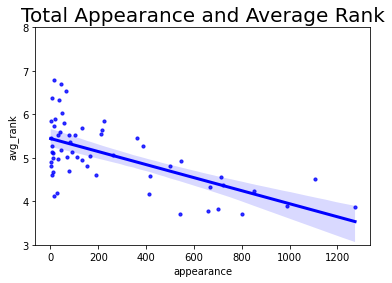

In [29]:
def get_regplot(df, col1_name, col2_name, color = 'blue'):
    sns.regplot(data = df,
                x = col1_name,
                y = col2_name,
#                 ci = None,
                color = color,
                line_kws = {
#                             'color' : 'grey',
                            'lw' : 3
                },
                scatter_kws = {'s' : 10,
#                               'color' : 'grey'
                              })
    
    plt.ylim([3, 8])

def get_pearsonr(col1, col2):
    corrcoef, p_value = stats.pearsonr(x = col1,
                                       y = col2)
    print(f"상관계수 : {corrcoef}, p-value : {p_value}")
    
get_regplot(app_rank, 'appearance', 'avg_rank')
get_pearsonr(app_rank['appearance'], app_rank['avg_rank'])
plt.title("Total Appearance and Average Rank", fontsize = 20)

상관계수 : -0.6305955921051908, p-value : 5.43089806006367e-07


Text(0.5, 1.0, 'Dirt : Appearance and Average Rank')

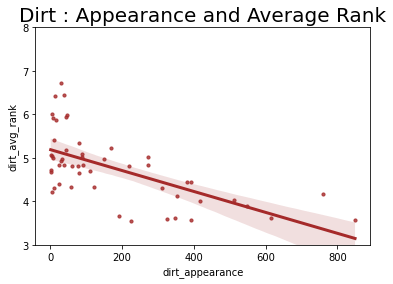

In [30]:
# sns.set_palette(sns.color_palette(dirt_colors))
get_regplot(dirt_app_rank, 'dirt_appearance', 'dirt_avg_rank', color = 'brown')
get_pearsonr(dirt_app_rank['dirt_appearance'], dirt_app_rank['dirt_avg_rank'])
plt.title("Dirt : Appearance and Average Rank", fontsize = 20)

상관계수 : -0.5625490140785173, p-value : 0.000105486902442249


Text(0.5, 1.0, 'Turf : Appearance and Average Rank')

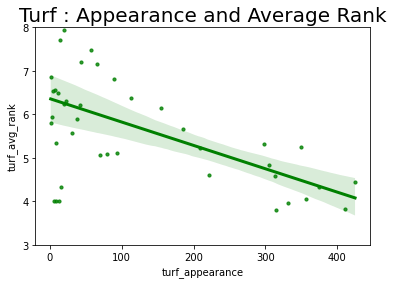

In [31]:
turf_palette
get_regplot(turf_app_rank, 'turf_appearance', 'turf_avg_rank', color = 'green')
get_pearsonr(turf_app_rank['turf_appearance'], turf_app_rank['turf_avg_rank'])
plt.title("Turf : Appearance and Average Rank", fontsize = 20)

### 경기장 보기
- [참고](https://www.kaggle.com/code/iamleonie/big-data-derby-step-by-step-analysis#Missing-Data) 
    - 경,위도 데이터를 보고 경기장을 그릴 수 있다는 생각은 못했다. 아이디어만 보고 구현은 직접 해본다

In [32]:
track = start_df['track_id'].unique()
total_df = race_df.merge(track_df, on = ['track_id', 'race_date', 'race_number'])

In [33]:
track_lst = race_df['track_id'].unique()
track_lst

array(['AQU', 'BEL', 'SAR'], dtype=object)

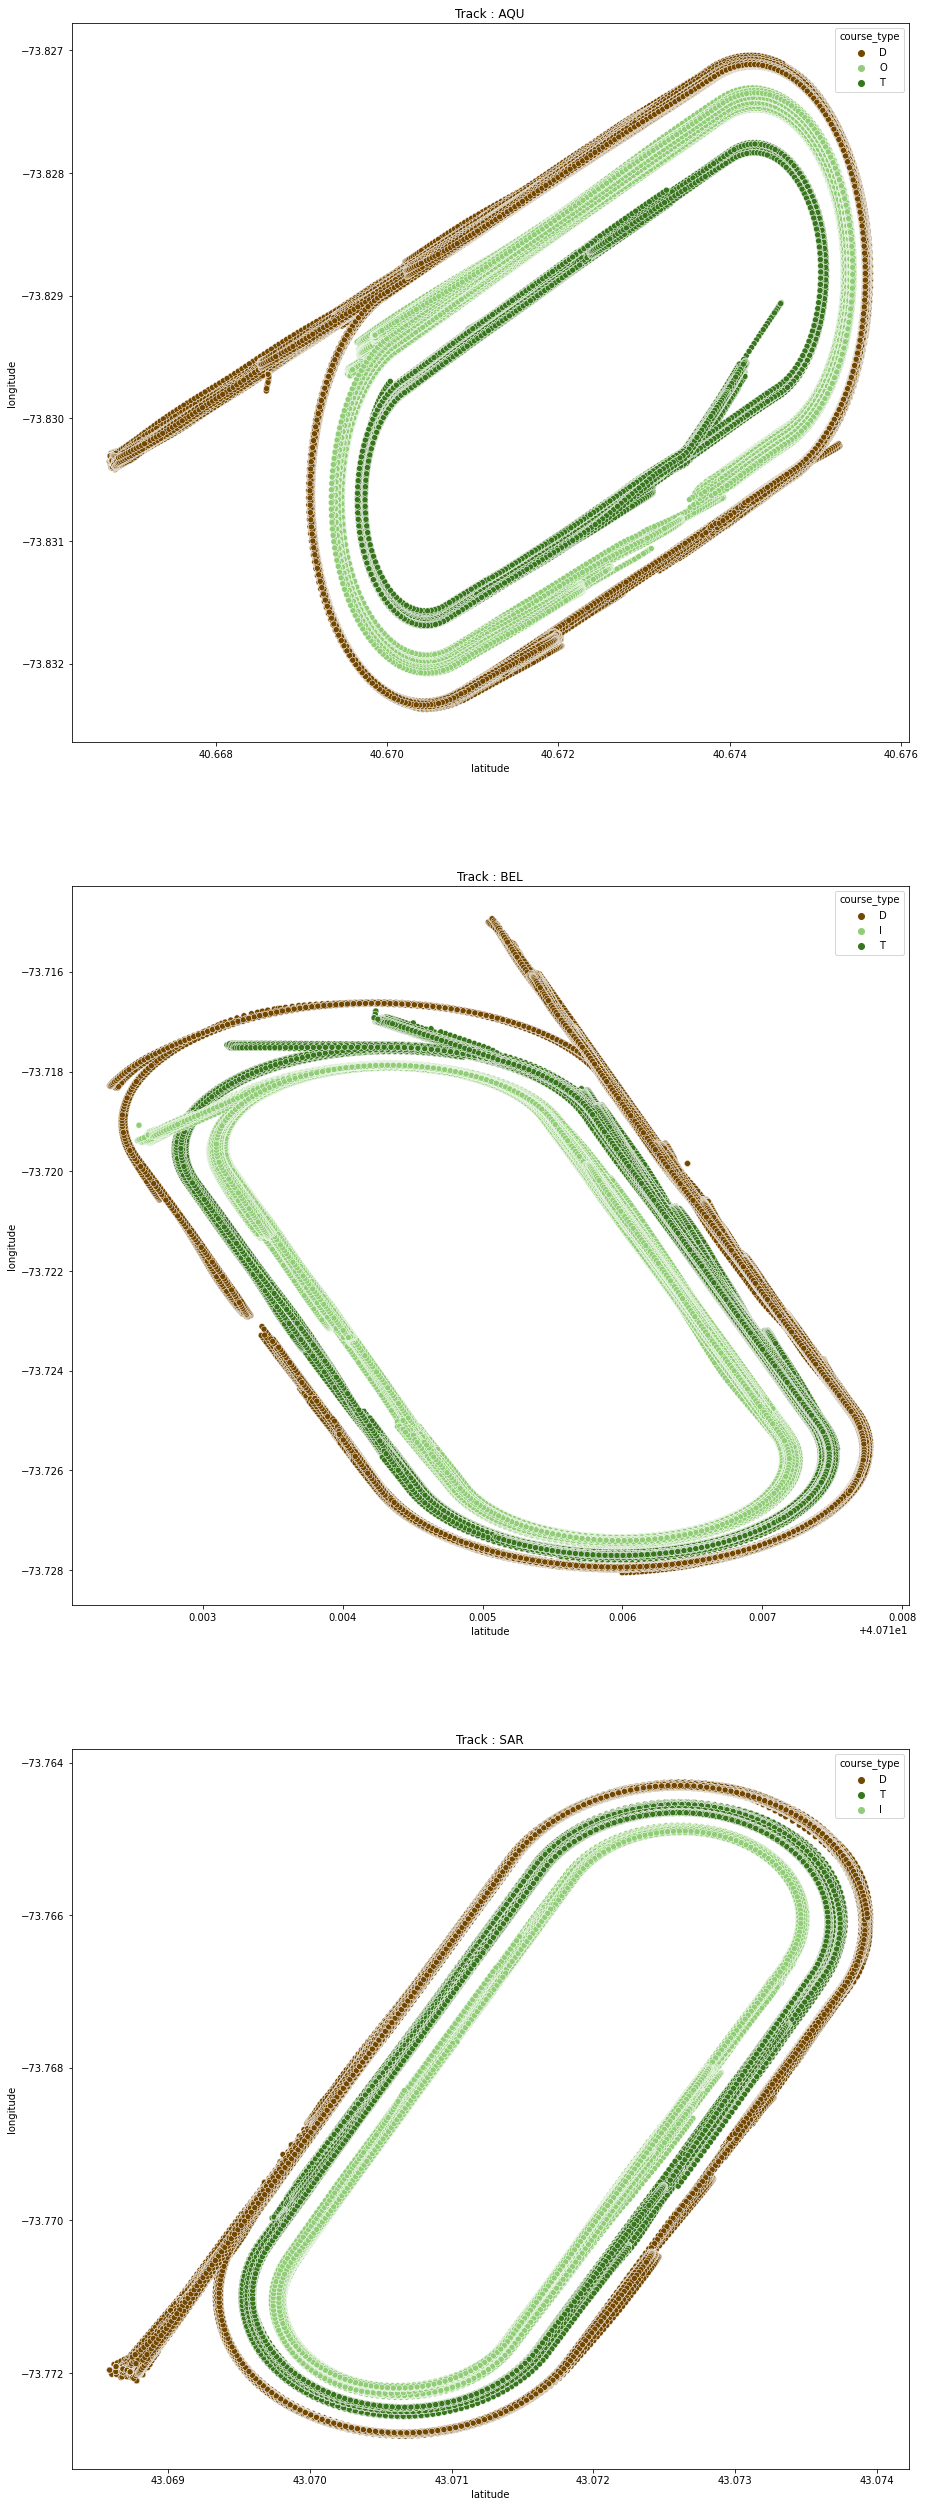

In [34]:
# 경기장을 나타내는 점들이기 때문에 사실 하려는 거에 비해 점이 너무 많긴 함
# 이를 줄여줘도 됨

fig, ax = plt.subplots(3, 1, figsize = (15, 45))
track_palette = {'D' : '#744700',
        'T' : '#38761d',
        'I' : '#91cd76',
        'O' : '#91cd76', 
        'M' : '#d9ead3'}

for i, v in enumerate(track_lst):
    temp_df = (
                total_df[(total_df['track_id'] == v) & 
                        (total_df['trakus_index'].isin(list(range(0, 200)))) &
                        (total_df['program_number'].isin(['1', '2', '3']))
                       ]
                        [['course_type', 'latitude', 'longitude']]
                )

    sns.scatterplot(data = temp_df,
                       x = 'latitude',
                       y = 'longitude',
                       hue = 'course_type',
                        ax = ax[i],
                   palette = track_palette)
    
    ax[i].set_title(f'Track : {v}')

# 경기 분석
- 가장 규모가 큰 `Stakes` 레이스만 분석해봄
- 경주 거리는 `3630 ~ 10560`까지 있음 (단위 : 피트)
- `run_up_distance` : `9 ~ 246` 
- `trakus_index`는 시간 순서대로 잘 찍혀 있다. 근데 `track_df`에 `trakus_index`가 오름차순으로 정렬되어 있지 않을 뿐이다.
    - 이걸 오해해서 하루를 날렸다. 근데 덕분에 `groupby.cumcount()`라는 유용한 함수를 알게 됨


In [35]:
race_track = track_df.merge(race_df, on = ['race_id', 'track_id', 'race_date', 'race_number'])
# race_track.insert(0, 'race_id', race_track.pop('race_id'))
race_track.drop(['track_id', 'race_date', 'race_number'], axis = 1, inplace = True)
race_track.head(2)

,program_number,trakus_index,latitude,longitude,race_id,distance_id,course_type,run_up_distance,race_type,distance_feet,dirt_condition,turf_condition,month,season
0,6,72,40.672902,-73.827607,AQU_2019-01-01_9,600,D,48,CLM,3960,GD,NaN,1,winter
1,6,73,40.672946,-73.827587,AQU_2019-01-01_9,600,D,48,CLM,3960,GD,NaN,1,winter


In [36]:
stakes = race_track[race_track['race_type'] == 'STK'][:] # 경기 거리는 3630 ~ 10560까지 있다
stk_dirt = stakes[stakes['course_type'] == 'D'][:].drop('turf_condition', axis = 1)

## 레이스 하나를 선정하고 분석하기
- STK 아무 경기나 하나 잡고, 각 주행자의 Trakus Index 별 속도를 측정하겠음
- Trakus 인덱스 간 간격이 0.25초라고 명시되었기 때문에 속도를 구할 수 있을 것
- `haversine` 라이브러리를 적용함 

In [37]:
# trakus_index로 계산
race_name = 'SAR_2019-08-10_8'
test_race = stk_dirt[stk_dirt['race_id'] == race_name][:]

test_race['next_lat'] = test_race.sort_values(by = ['program_number', 'trakus_index']).groupby('program_number')['latitude'].shift(-1)
test_race['next_lon'] = test_race.sort_values(by = ['program_number', 'trakus_index']).groupby('program_number')['longitude'].shift(-1)

test_race.loc[test_race['next_lat'].notnull(), 'moved'] = (test_race.apply
                                                                           (lambda x : haversine((x['latitude'], x['longitude']), 
                                                                                                 (x['next_lat'], x['next_lon']), 
                                                                                                  unit = 'ft'), 
                                                                            axis = 1)
                                                            )

test_race['velocity_ft/s'] = test_race['moved'] / 0.25 # feet per second
test_race['moved_km'] = test_race['moved'].apply(lambda x : x / 3281)
test_race['velocity_km/h'] = test_race['velocity_ft/s'].apply(lambda x : x / 3281 * 3600)
test_race['elapsed_time'] = (test_race['trakus_index'] - 1) * 0.25
test_race['total_distance'] = test_race.sort_values(by = ['program_number', 'trakus_index']).groupby('program_number')['moved'].cumsum()


In [38]:
test_race.describe()

,trakus_index,latitude,longitude,distance_id,run_up_distance,distance_feet,month,next_lat,next_lon,moved,velocity_ft/s,moved_km,velocity_km/h,elapsed_time,total_distance
count,2184.000000,2184.000000,2184.000000,2184.0,2184.0,2184.0,2184.0,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2184.000000,2177.000000
mean,156.500000,43.071951,-73.767849,650.0,72.0,4290.0,8.0,43.071960,-73.767838,15.431852,61.727407,0.004703,67.728944,38.875000,2518.035731
std,90.086806,0.001455,0.002347,0.0,0.0,0.0,0.0,0.001448,0.002343,2.443056,9.772224,0.000745,10.722343,22.521702,1442.932124
min,1.000000,43.069083,-73.772297,650.0,72.0,4290.0,8.0,43.069087,-73.772297,2.380095,9.520380,0.000725,10.446013,0.000000,2.380095
25%,78.750000,43.070772,-73.769925,650.0,72.0,4290.0,8.0,43.070786,-73.769908,14.059172,56.236686,0.004285,61.704380,19.437500,1270.121971
50%,156.500000,43.072210,-73.767895,650.0,72.0,4290.0,8.0,43.072213,-73.767870,15.869859,63.479434,0.004837,69.651315,38.875000,2596.804720
75%,234.250000,43.073190,-73.765678,650.0,72.0,4290.0,8.0,43.073191,-73.765673,17.423792,69.695168,0.005311,76.471382,58.312500,3800.819273
max,312.000000,43.073948,-73.764287,650.0,72.0,4290.0,8.0,43.073948,-73.764287,19.008678,76.034712,0.005794,83.427298,77.750000,4901.007789


Text(0.5, 1.0, 'race SAR_2019-08-10_8 : Time and Distance')

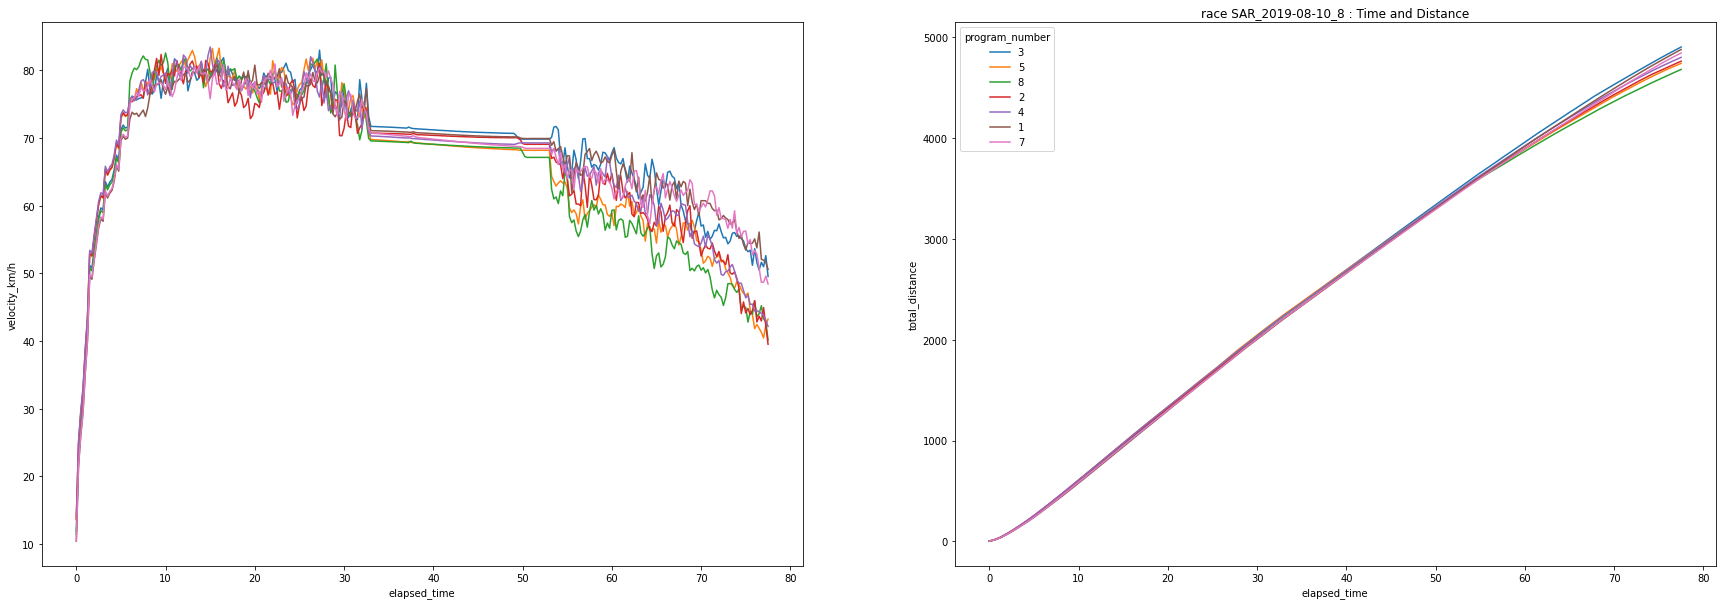

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (30, 10))

sns.lineplot(data = test_race,
            x = 'elapsed_time',
            y = 'velocity_km/h',
            hue = 'program_number',
            ax = ax[0])
plt.title(f"race {'SAR_2019-08-10_8'} : Time and Velocity")

ax[0].legend().set_visible(False)

sns.lineplot(data = test_race,
            x = 'elapsed_time',
            y = 'total_distance',
            hue = 'program_number',
            ax = ax[1])

plt.title(f"race {'SAR_2019-08-10_8'} : Time and Distance")

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

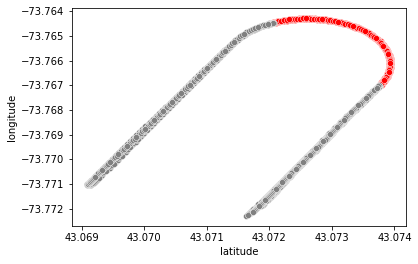

In [40]:
# 30초 ~ 50초 즘에서 나오는 속도가 일정하게 유지되는 구간이 궁금하다

data = test_race[test_race['elapsed_time'].between(31, 50, inclusive = "both")][:]
else_data = test_race[test_race['elapsed_time'].between(31, 50, inclusive = "both") == False][:]

sns.set_palette(turf_palette)
sns.scatterplot(data = data,
               x = 'latitude',
               y = 'longitude',
               color = 'red')

sns.scatterplot(data = else_data,
               x = 'latitude',
               y = 'longitude',
               color = 'grey')


## Stake 테이블에서 속도 뽑기
- 위에서 개별 경기에 대해 진행한 과정을 전체 Stake 경주에 대해 적용

In [41]:
stakes_raw = race_track[race_track['race_type'] == 'STK'][:] # 경기 거리는 3630 ~ 10560까지 있다
stakes_raw.drop(['distance_id', 'race_type', 'month', 'season'], axis = 1, inplace = True)
stakes_raw.head(2)

,program_number,trakus_index,latitude,longitude,race_id,course_type,run_up_distance,distance_feet,dirt_condition,turf_condition
127497,1,1,43.072430,-73.770416,SAR_2019-08-03_9,D,77,5940,FT,NaN
127498,1,2,43.072427,-73.770422,SAR_2019-08-03_9,D,77,5940,FT,NaN


In [42]:
stakes_raw['next_lat'] = stakes_raw.sort_values(by = ['race_id', 'program_number', 'trakus_index']).groupby(['race_id', 'program_number'])['latitude'].shift(-1)
stakes_raw['next_lon'] = stakes_raw.sort_values(by = ['race_id', 'program_number', 'trakus_index']).groupby(['race_id', 'program_number'])['longitude'].shift(-1)

stakes_raw.loc[stakes_raw['next_lat'].notnull(), 'moved_ft'] = (stakes_raw.apply
                                                                           (lambda x : haversine((x['latitude'], x['longitude']), (x['next_lat'], x['next_lon']), 
                                                                                                  unit = 'ft'
                                                                                                ),
                                                                            axis = 1)
                                                            )
stakes_raw['velocity_ft'] = stakes_raw['moved_ft'] / 0.25 # feet per second
stakes_raw.loc[stakes_raw['next_lat'].notnull(), 'moved_km'] = (stakes_raw.apply
                                                                           (lambda x : haversine((x['latitude'], x['longitude']), (x['next_lat'], x['next_lon']), 
                                                                                                  unit = 'km'
                                                                                                ),
                                                                            axis = 1)
                                                            )
stakes_raw['velocity_km/h'] = stakes_raw['moved_km'].apply(lambda x : x / 0.25 * 3600)
stakes_raw['elapsed_time'] = (stakes_raw['trakus_index'] - 1) * 0.25
stakes_raw['player_cumulative_moved'] = stakes_raw.sort_values(by = ['race_id', 'program_number', 'trakus_index']).groupby(['race_id', 'program_number'])['moved_km'].cumsum()

stakes_raw

,program_number,trakus_index,latitude,longitude,race_id,course_type,run_up_distance,distance_feet,dirt_condition,turf_condition,next_lat,next_lon,moved_ft,velocity_ft,moved_km,velocity_km/h,elapsed_time,player_cumulative_moved
127497,1,1,43.072430,-73.770416,SAR_2019-08-03_9,D,77,5940,FT,NaN,43.072427,-73.770422,1.935715,7.742859,0.000590,8.496084,0.00,0.000590
127498,1,2,43.072427,-73.770422,SAR_2019-08-03_9,D,77,5940,FT,NaN,43.072420,-73.770438,4.918765,19.675059,0.001499,21.589049,0.25,0.002089
127499,1,3,43.072420,-73.770438,SAR_2019-08-03_9,D,77,5940,FT,NaN,43.072413,-73.770453,4.852418,19.409673,0.001479,21.297846,0.50,0.003568
127500,1,4,43.072413,-73.770453,SAR_2019-08-03_9,D,77,5940,FT,NaN,43.072405,-73.770472,5.651526,22.606102,0.001723,24.805224,0.75,0.005291
127501,1,5,43.072405,-73.770472,SAR_2019-08-03_9,D,77,5940,FT,NaN,43.072393,-73.770497,7.961507,31.846029,0.002427,34.944010,1.00,0.007718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5160524,7,8,43.069156,-73.770873,SAR_2019-08-10_8,D,72,4290,FT,NaN,43.069171,-73.770835,11.265120,45.060479,0.003434,49.443962,1.75,0.018244
5160525,7,9,43.069171,-73.770835,SAR_2019-08-10_8,D,72,4290,FT,NaN,43.069186,-73.770796,11.879136,47.516544,0.003621,52.138954,2.00,0.021865
5160526,7,10,43.069186,-73.770796,SAR_2019-08-10_8,D,72,4290,FT,NaN,43.069202,-73.770754,12.443253,49.773012,0.003793,54.614931,2.25,0.025657
5160527,7,11,43.069202,-73.770754,SAR_2019-08-10_8,D,72,4290,FT,NaN,43.069218,-73.770711,12.997285,51.989141,0.003962,57.046644,2.50,0.029619


In [43]:
stakes_raw.describe()

,trakus_index,latitude,longitude,run_up_distance,distance_feet,next_lat,next_lon,moved_ft,velocity_ft,moved_km,velocity_km/h,elapsed_time,player_cumulative_moved
count,683284.000000,683284.000000,683284.000000,683284.000000,683284.000000,681485.000000,681485.000000,681485.000000,681485.000000,681485.000000,681485.000000,683284.000000,681485.000000
mean,199.748876,41.359431,-73.770485,75.133353,5553.599250,41.359401,-73.770486,15.334716,61.338865,0.004674,67.305910,49.687219,0.936687
std,125.943871,1.065971,0.045018,39.163384,1236.535413,1.065954,0.045014,2.127073,8.508292,0.000648,9.335979,31.485968,0.592307
min,1.000000,40.666761,-73.832583,9.000000,3630.000000,40.666761,-73.832583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,96.000000,40.674425,-73.828161,48.000000,4620.000000,40.674429,-73.828157,14.789588,59.158352,0.004508,64.913276,23.750000,0.445389
50%,191.000000,40.715017,-73.767401,72.000000,5280.000000,40.715018,-73.767393,15.733606,62.934424,0.004796,69.056685,47.500000,0.909818
75%,288.000000,43.069939,-73.724876,86.000000,5940.000000,43.069943,-73.724884,16.475938,65.903753,0.005022,72.314870,71.750000,1.361907
max,738.000000,43.073992,-73.714826,246.000000,10560.000000,43.073992,-73.714934,250.663232,1002.652927,0.076402,1100.191004,184.250000,3.416150


 ## 이상치 데이터 정리
- 말이 최대로 찍은 순간속도는 88km/h이라고 한다.[관련 정보](http://www.speedofanimals.com/animals/horse)

#### 참고 : 위도, 경도 데이터의 소수점 갯수와 그에 따른 오차
- [관련 링크](https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude)
- 내가 제대로 이해한 게 맞다면
    - 일반적으로 위도`latitude` 1도는 111111m를 덮는다고 알려져 있다. $\frac{10^7}{90}$
    - 경도`longitude` 또한 위도와 비슷하거나 작다. 작아지는 이유는 극으로 갈수록 폭이 좁아지기 때문임
    - 따라서 소수점 6째자리까지 표현된 위도, 경도 데이터가 갖는 오차는 $0.11m = 0.00011km$ 정도이다.
    - 그리고 속도가 가질 수 있는 오차는 $0.00011 \times 4 \times 3600$ = $1.584km/h$이다. (위치는 0.25초마다 찍힘)
    - 계산이 맞나 모르겠음. 비판 환영합니다..
- 따라서 $89.584km/h$보다 큰 값은 모두 이상치 취급하고, 이상치가 들어간 레이스는 제외하겠음

In [44]:
# outliers = stakes[stakes['velocity_km/h'] >= 89.584][:] 
outliers = stakes_raw[stakes_raw['velocity_km/h'] >= 89.584][:] 

outliers.shape # (218, 24)
outliers_races = outliers['race_id'].unique() # 64개의 레이스에 이상치 데이터가 있음 / Stakes 전체 253개

In [45]:
stakes = stakes_raw.drop(stakes_raw[stakes_raw['race_id'].isin(outliers_races)].index)
stakes['race_id'].nunique() # 189

189

### 1. 일단 Dirt vs Turf부터 시작

### 요약
1. `Turf`의 평균 속도는 `Dirt`의 평균 속도보다 높았음 ($67.97km/h$ vs $66.30km/h$)
    - 다른 변인은 더 조사해봐야 함. 경주 거리라든지, 말의 무게라든지.
2. 경기장 컨디션(`dirt_condition`, `turf_condition`)의 경우 땅이 습기를 머금을수록 공통적으로 평균속도가 낮아짐
    - 가장 좋은 컨디션과 안 좋은 컨디션을 비교했을 때, `Turf`의 평균 속도 감소율이 더 높았음($6.7$%, `Dirt` : $3.2$%)
3. Inner Turf, Turf, Outer Turf에 따른 차이가 거의 없었음. 
    - 경기장마다 무엇을 어디로 정의했느냐 차이가 있지만, 공통적으로 트랙 자체의 성질만 놓는다면 `Turf`로 묶어도 무방할 것이라 생각됨.

Text(0, 0.5, 'average speed')

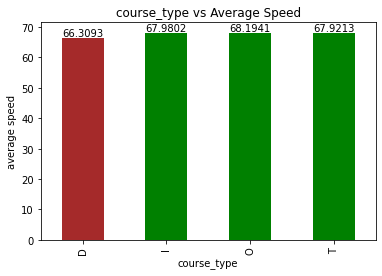

In [46]:
# 1. 바닥 상태에 따른 평균 속도 : 별 차이 없어 보임
ax = stakes.groupby('course_type')['velocity_km/h'].mean().plot(kind = 'bar', color = ['brown'] + ['green'] * 3)
ax.bar_label(ax.containers[0])
plt.title("course_type vs Average Speed")
plt.ylabel('average speed')

Text(0.5, 1.0, 'Dirt : Track Condition and Average Speed')

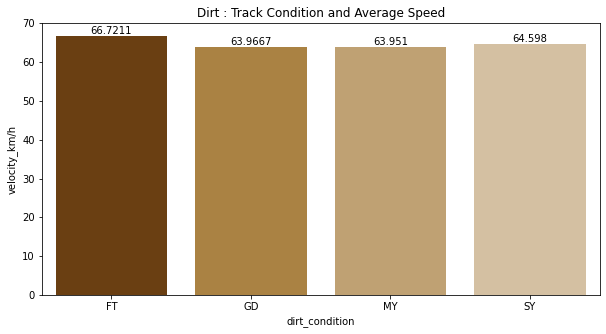

In [47]:
# 2. 바닥과 바닥 컨디션에 따른 평균 속도

# 1. Dirt
dirt = stakes[stakes['course_type'] == 'D'].groupby('dirt_condition')['velocity_km/h'].mean().to_frame().reset_index()

plt.figure(figsize = (10, 5))
ax = sns.barplot(data = dirt,
           x = 'dirt_condition',
           y = 'velocity_km/h',
           palette = dirt_palette)
ax.bar_label(ax.containers[0])
plt.title("Dirt : Track Condition and Average Speed")

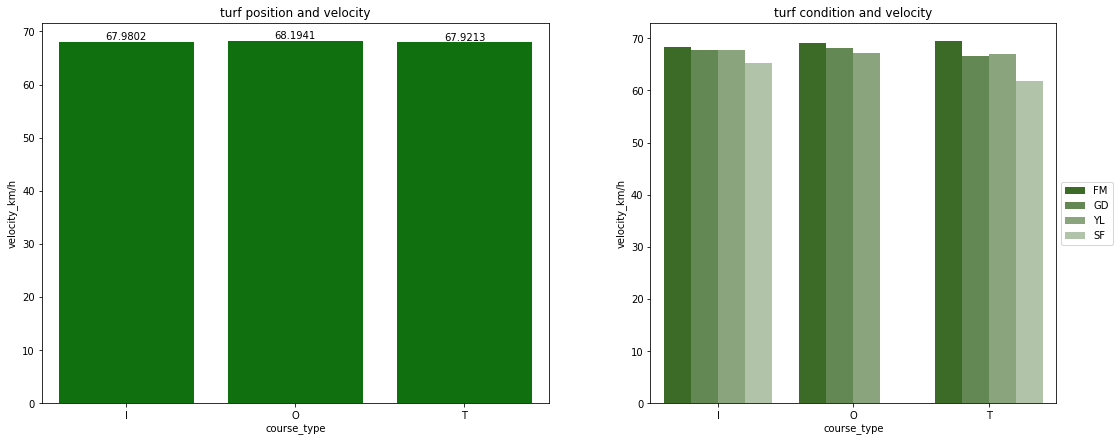

In [48]:
# 2. turf
turf = stakes[stakes['course_type'].isin(['T', 'I', 'O'])].groupby(['course_type', 'turf_condition'])['velocity_km/h'].mean().to_frame().reset_index()
tio = stakes[stakes['course_type'].isin(['T', 'I', 'O'])].groupby(['course_type'])['velocity_km/h'].mean().to_frame().reset_index()
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

sns.barplot(data = tio,
           x = 'course_type',
           y = 'velocity_km/h',
           color = 'green',
           ax = ax[0])
ax[0].set_title('turf position and velocity')
ax[0].bar_label(ax[0].containers[0])


sns.barplot(data = turf,
           x = 'course_type',
           y = 'velocity_km/h',
           hue = 'turf_condition',
           palette = turf_palette,
           ax = ax[1])
ax[1].set_title('turf condition and velocity')

box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[1].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

In [49]:
# T, I, O에 따른 속도 차이가 거의 없어 보임
# 따라서 T, I, O를 모두 Turf로 합친 다음에 평균 속도를 보겠음

turf = stakes[stakes['course_type'].isin(['T', 'I', 'O'])][:]
turf.loc[turf['course_type'].isin(['I', 'O']), 'course_type'] = 'T'
# turf['course_type'].unique()
turf = turf.groupby(['course_type', 'turf_condition'])['velocity_km/h'].mean().to_frame().reset_index()

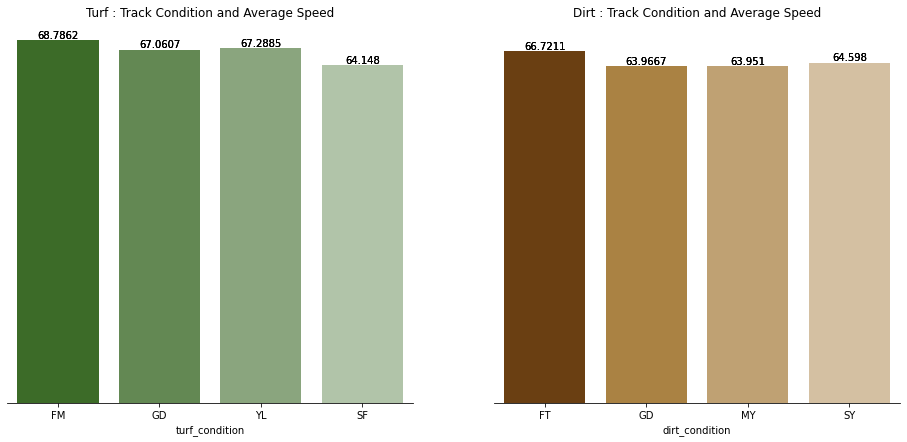

In [50]:
# 시각화는 Dirt와 동시에 보자
fig, ax = plt.subplots(1, 2, figsize = (16, 7), sharey = True)

sns.barplot(data = turf, 
            x = 'turf_condition', 
            y = 'velocity_km/h', 
            ax = ax[0])
ax[0].set_title("Turf : Track Condition and Average Speed")


sns.barplot(data = dirt,
           x = 'dirt_condition',
           y = 'velocity_km/h',
           palette = dirt_palette,
           ax = ax[1])
ax[1].set_title("Dirt : Track Condition and Average Speed")

for i in range(2):
    for j in ['left', 'top', 'right']:
        ax[i].bar_label(ax[i].containers[0])
        ax[i].spines[j].set_visible(False)
        ax[i].get_yaxis().set_visible(False)

Text(0.5, 1.0, 'Course Type and Average Speed')

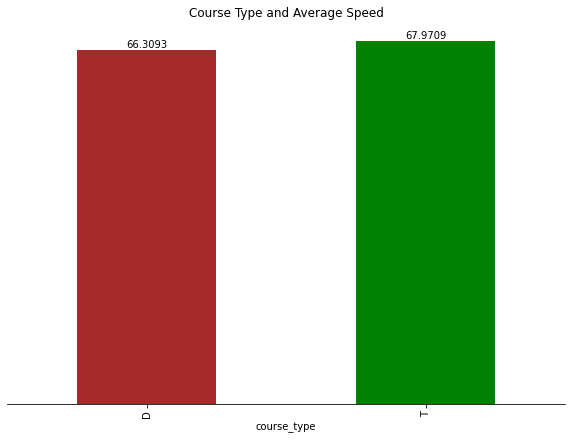

In [51]:
stakes.loc[stakes['course_type'].isin(['I', 'O']), 'course_type'] = 'T'
plt.figure(figsize = (10, 7))
stakes.groupby('course_type')['velocity_km/h'].mean().plot(kind = 'bar', color = ['brown', 'green'])
plt.gca().bar_label(plt.gca().containers[0])
for j in ['left', 'top', 'right']:
    plt.gca().spines[j].set_visible(False)

plt.yticks(ticks = [])

plt.title("Course Type and Average Speed")


In [52]:
stakes = stakes[['race_id', 'program_number', 'trakus_index', 'latitude', 'longitude', 'next_lat', 'next_lon',
                'course_type', 'dirt_condition', 'turf_condition', 'run_up_distance', 'moved_km', 'velocity_km/h', 'elapsed_time']]
# stakes['track_id'] = stakes['race_id'].apply(lambda x : x[0:3])
stakes = stakes.merge(start_df, on = ['race_id', 'program_number'])
stakes.insert(1, 'track_id', stakes.pop('track_id'))
stakes.loc[stakes['course_type'].isin(['I', 'O']), 'course_type'] = 'T'

### 1. 무게와 평균속도

#### 요약
- 무게가 무거울수록 평균 속도가 낮을 것이라는 통념과 달리, **뚜렷한 경향성을 보이진 않았다.**
- 오히려 **Turf에서 더 빨리 달릴 수 있다는 위의 내용을 다시 한 번 보여준 느낌**

Text(0.5, 1.0, 'weight histogram')

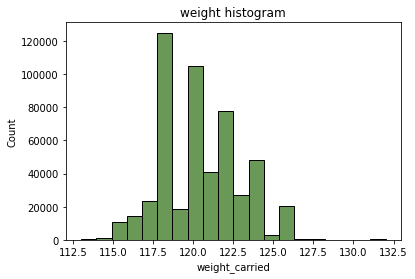

In [53]:
sns.histplot(data = stakes,
            x = 'weight_carried',
#              kde = True,
            bins = 20)
plt.title("weight histogram")

Text(0, 0.5, 'average speed')

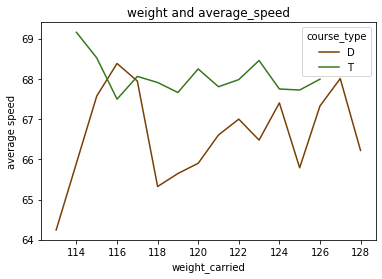

In [54]:
temp_df = stakes[['race_id', 'program_number', 'course_type', 'dirt_condition', 'turf_condition', 'weight_carried', 'velocity_km/h', 'elapsed_time', 'position_at_finish']]
temp_df = temp_df[temp_df['weight_carried'].between(110, 130, inclusive = 'both')][:]
# print(temp_df.head(2))
temp_df = temp_df.groupby(['weight_carried', 'course_type'])['velocity_km/h'].agg(['mean', 'count']).dropna().reset_index()

sns.lineplot(data = temp_df,
           x = 'weight_carried',
           y = 'mean',
           hue = 'course_type',
          palette = [dirt_palette[0], turf_palette[0]])

plt.title('weight and average_speed')
plt.ylabel("average speed")

## 

### 가정 2 평균 무게에 따른 평균 속도

#### 요약
- 각 경기의 평균 무게에 따른 평균 속도 -> 뚜렷한 경향을 얻지 못함

In [55]:
temp_df = stakes[['race_id', 'program_number', 'course_type', 'velocity_km/h', 'weight_carried']]
temp_df.head(2)

,race_id,program_number,course_type,velocity_km/h,weight_carried
0,AQU_2019-02-17_7,5,D,58.907865,120
1,AQU_2019-02-17_7,5,D,59.773105,120


In [56]:
temp_df.loc[:, 'race_avg_weight'] = temp_df.groupby('race_id')['weight_carried'].transform('mean')
temp_df.loc[:, 'race_avg_speed'] = temp_df.groupby('race_id')['velocity_km/h'].transform('mean')
temp_df.loc[:, 'player_avg_speed'] = temp_df.groupby(['race_id', 'program_number'])['velocity_km/h'].transform('mean')
temp_df.head(2)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,race_id,program_number,course_type,velocity_km/h,weight_carried,race_avg_weight,race_avg_speed,player_avg_speed
0,AQU_2019-02-17_7,5,D,58.907865,120,120.666667,66.383882,65.396976
1,AQU_2019-02-17_7,5,D,59.773105,120,120.666667,66.383882,65.396976


In [57]:
temp_df2 = temp_df.groupby(['course_type', 'race_avg_weight'])['race_avg_speed'].mean()
temp_df2

course_type  race_avg_weight
D            117.285714         66.439945
             117.400000         68.750402
             117.428571         68.356895
             117.571429         69.142408
             117.818182         66.922983
                                  ...    
T            123.142857         71.625509
             123.800000         70.070210
             124.000000         68.756617
             124.181818         65.691376
             126.000000         67.415240
Name: race_avg_speed, Length: 132, dtype: float64

Text(0.5, 1.0, 'Turf : Average Weight and Average Speed')

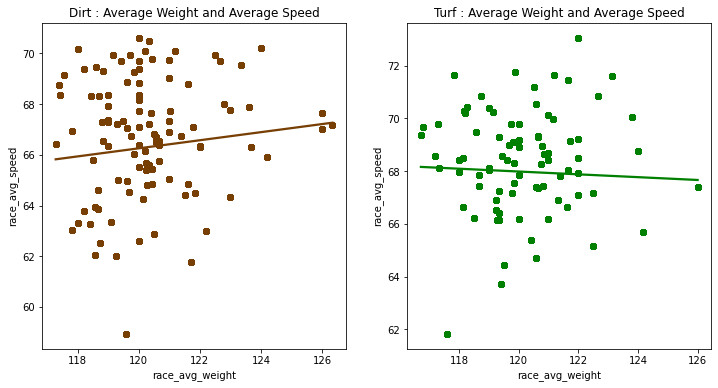

In [58]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sns.regplot(data = temp_df[temp_df['course_type'] == 'D'][:], 
             x = 'race_avg_weight', 
             y = 'race_avg_speed', 
             color = dirt_palette[0],
#              ci = True,
             ax = ax[0]
            )
ax[0].set_title('Dirt : Average Weight and Average Speed')


sns.regplot(data = temp_df[temp_df['course_type'] == 'T'][:], 
             x = 'race_avg_weight', 
             y = 'race_avg_speed', 
             color = 'green',
#             ci = True,
             ax = ax[1]
            )
ax[1].set_title('Turf : Average Weight and Average Speed')


### 가정 3 : 총 주행거리에 따른 평균 속도

#### 요약
1. 당연한 얘기지만, **주행 거리가 길수록 평균 속도가 감소**하는 경향이 있음
2. 각 **레이스의 주행 거리**는 연속적이지 않고 **이산적임**(이걸 이제 알았다)
    - `race_df`에서 허들 레이스를 제외한 1991개의 데이터 중, 주행 거리의 고윳값은 16개임
    - `stakes`로 오면 레이스는 총 189개의 데이터가 있고 주행 거리의 고윳값은 14개임
3. 트랙 상태에 따른 감소폭은 가장 관리가 잘 된 상태를 제외하면 제대로 설명하긴 힘들 것 같음

In [59]:
temp_df = stakes[['race_id', 'course_type', 'dirt_condition', 'turf_condition', 'program_number', 'moved_km', 'velocity_km/h', 'elapsed_time']]
temp_df = temp_df.merge(race_df[['race_id', 'distance_feet']], on = 'race_id')
temp_df['race_distance_km'] = temp_df['distance_feet'].apply(lambda x : x / 3281)
temp_df = temp_df.drop('distance_feet', axis = 1)
temp_df['race_avg_speed_km/h'] = temp_df.groupby(['race_id'])['velocity_km/h'].transform('mean')

Text(0.5, 1.0, 'Dirt : Race Distance and Average Speed')

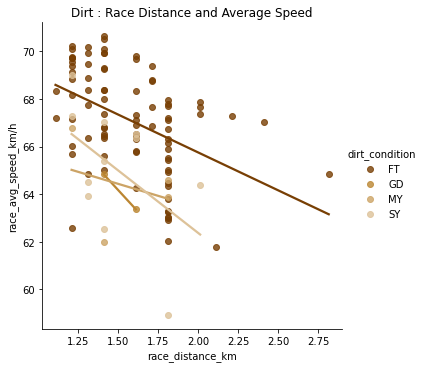

In [60]:
temp_df = temp_df[['race_id', 'course_type', 'dirt_condition', 'turf_condition', 'race_distance_km', 'race_avg_speed_km/h']].drop_duplicates()

# fig, ax = plt.subplots(1, 2, figsize = (16, 9), sharex = True, sharey = True)

sns.lmplot(data = temp_df[temp_df['course_type'] == 'D'][:], 
            x = 'race_distance_km', 
            y = 'race_avg_speed_km/h', 
            hue = 'dirt_condition',
            palette = dirt_palette,
#            ax = ax[0],
           ci = False
          )
plt.title("Dirt : Race Distance and Average Speed")
# ax[0].set_title("Dirt : Race Distance and Average Speed")

Text(0.5, 1.0, 'Turf : Race Distance and Average Speed')

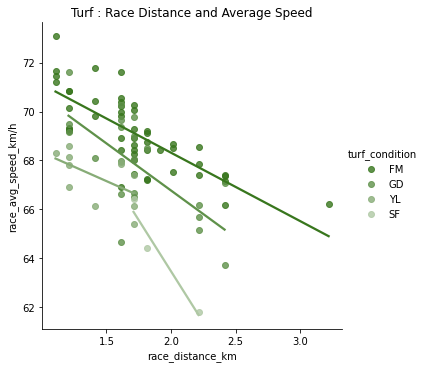

In [61]:
sns.lmplot(data = temp_df[temp_df['course_type'] == 'T'][:], 
            x = 'race_distance_km', 
            y = 'race_avg_speed_km/h', 
            hue = 'turf_condition',
            palette = turf_palette,
#            ax = ax[1],
           ci = False
          )
# ax[1].set_title("Turf : Race Distance and Average Speed")
plt.title("Turf : Race Distance and Average Speed")

<AxesSubplot:xlabel='race_distance_km', ylabel='Count'>

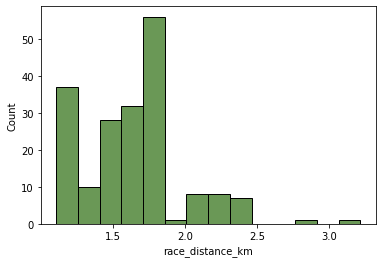

In [62]:
sns.histplot(temp_df['race_distance_km'], bins = 14)

### 가정 4 : 경기장에 따른 평균 속도

#### 요약
1. 경기장만 놓고 보면 평균 속도는 BEL > SAR > AQU이다.


In [63]:
stakes.columns

Index(['race_id', 'track_id', 'program_number', 'trakus_index', 'latitude',
       'longitude', 'next_lat', 'next_lon', 'course_type', 'dirt_condition',
       'turf_condition', 'run_up_distance', 'moved_km', 'velocity_km/h',
       'elapsed_time', 'race_date', 'race_number', 'weight_carried', 'jockey',
       'odds', 'position_at_finish'],
      dtype='object')

In [64]:
stadium_df = stakes[['race_id', 'track_id', 'course_type', 'dirt_condition', 'turf_condition', 'velocity_km/h']]
track_velo =  stadium_df.groupby(['track_id', 'course_type'])['velocity_km/h'].agg(['count', 'mean']).reset_index().dropna()
track_dirt_velo =  stadium_df[stadium_df['course_type'] == 'D'][:].groupby(['track_id', 'dirt_condition'])['velocity_km/h'].agg(['count', 'mean']).reset_index().dropna()
track_turf_velo =  stadium_df[stadium_df['course_type'] == 'T'][:].groupby(['track_id', 'turf_condition'])['velocity_km/h'].agg(['count', 'mean']).reset_index().dropna()

In [65]:
track_dirt_velo.columns

Index(['track_id', 'dirt_condition', 'count', 'mean'], dtype='object')

[Text(0, 0, '65.7391'), Text(0, 0, '68.2373'), Text(0, 0, '67.6845')]

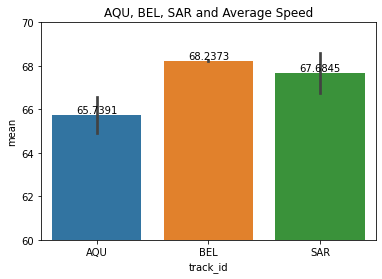

In [66]:
ax = sns.barplot(data = track_velo, x = 'track_id', y = 'mean', palette = 'tab10')
plt.title("AQU, BEL, SAR and Average Speed")
plt.ylim([60, 70])
ax.bar_label(ax.containers[0])

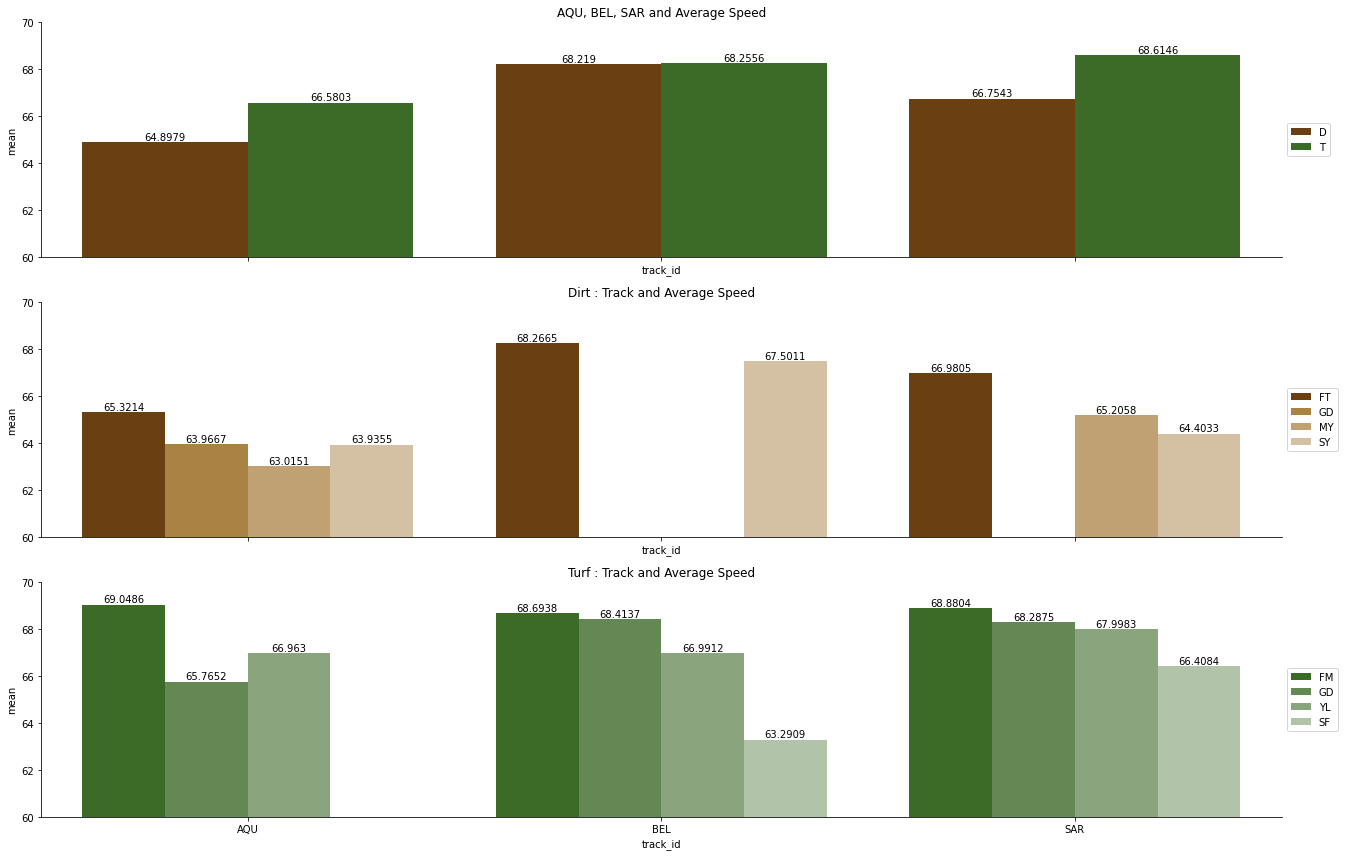

In [67]:
fig, ax = plt.subplots(3, 1, figsize = (18, 12), sharex = True, sharey = True)

sns.barplot(data = track_velo, x = 'track_id', y = 'mean', hue = 'course_type', palette = [dirt_palette[0], turf_palette[0]], ax = ax[0])
ax[0].set_title("AQU, BEL, SAR and Average Speed")

sns.barplot(data = track_dirt_velo, x = 'track_id', y = 'mean', hue = 'dirt_condition', palette = dirt_palette, ax = ax[1])
ax[1].set_title("Dirt : Track and Average Speed")

sns.barplot(data = track_turf_velo, x = 'track_id', y = 'mean', hue = 'turf_condition', palette = turf_palette, ax = ax[2])
ax[2].set_title("Turf : Track and Average Speed")

for i in range(3):
    box = ax[i].get_position()
    ax[i].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax[i].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    
    for j in ['top', 'right']:
        ax[i].spines[j].set_visible(False)
        
    for k in range(len(ax[i].containers)):
        ax[i].bar_label(ax[i].containers[k])

plt.setp(ax, ylim = (60, 70))
fig.tight_layout()

2. 더 뜯어봐야 알 것 같긴 하다. 
    - 유독 어떤 경기장에서 긴 레이스가 많았거나, 짧은 레이스가 많았을 수도 있음
    - 무게는 변수로 안 두겠음. 어쨌든 데이터에선 뚜렷한 경향을 볼 수 없었기 때문
    - `run_up_distance`는 진짜 뭔지 알고 싶다.